In [30]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import json
import csv
import markov_clustering as mc
from matplotlib.pylab import cm, axis
import math

### Read in binary purchase vectors as DataFrame and convert to a Pearson's Correlation matrix
The generation of these vectors has been handled using Rust, in `../rust_backend/src/main.rs`

In [46]:
# time the read operation
start = time.time()
vectors = pd.read_csv('data/rust_vectors.csv')
read_time = time.time() - start



print(f'Read in {read_time:.2f} seconds.\n{vectors.shape[0]:,}'+
      f' binary purchase vectors with {vectors.shape[1]:,} elements each.')

Read in 14.86 seconds.
5,203,319 binary purchase vectors with 45 elements each.


In [47]:
# Generate correlation matrix from purchase vectors (Pearson's)
corr = vectors.corr()

In [48]:
# verify that no null values exist in this DataFrame
assert(not vectors.isnull().values.any())

In [49]:
# Peek into DataFrame
vectors.head()

,Special Gasoline,Special Diesel,Lubricant,Diesel Auto Clean,Gasoline,Several,Filters,Additives And Fluids,Ethanol,Cigarettes,...,Toys,Covers,Pastas,Popcorn,Sweet Coconut James,Batteries,Mate Herb,Perfumery,Chas Juice Cafe In Powder,Special Diesel S10
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
vectors[(vectors.iloc[:, 2] == 1) & (vectors.iloc[:, 4] == 1)]

,Special Gasoline,Special Diesel,Lubricant,Diesel Auto Clean,Gasoline,Several,Filters,Additives And Fluids,Ethanol,Cigarettes,...,Toys,Covers,Pastas,Popcorn,Sweet Coconut James,Batteries,Mate Herb,Perfumery,Chas Juice Cafe In Powder,Special Diesel S10
5,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,1,1,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
37,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
48,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5203257,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5203259,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5203292,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5203298,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
cols = list(vectors.columns)

for i in range(len(cols)):
    print(f'{i}: {cols[i]}')

0: Special Gasoline
1: Special Diesel
2: Lubricant
3: Diesel Auto Clean
4: Gasoline
5: Several
6: Filters
7: Additives And Fluids
8: Ethanol
9: Cigarettes
10: Accessories
11: Popsicle And Ice Creams
12: Chewing Gum And Candy
13: Chips
14: The Bakery
15: Juices And Soft Drinks
16: Condom
17: Biscuits And Wafer
18: Flavoring
19: Pickets
20: Cold Alcoholic Beverages
21: Canisters
22: Chocolates
23: Extinguisher
24: Energy
25: Derivatives Peanuts
26: Coal
27: Dairy Products And Materials
28: Salted Biscuit
29: Cereals
30: Personal Hygiene
31: Diesel
32: Water
33: Hot Alcoholic Beverages
34: Slippers
35: Toys
36: Covers
37: Pastas
38: Popcorn
39: Sweet Coconut James
40: Batteries
41: Mate Herb
42: Perfumery
43: Chas Juice Cafe In Powder
44: Special Diesel S10


In [67]:
f = vectors[(vectors.iloc[:, 0] == 1) & (vectors.iloc[:, 3] == 1)].shape[0]

In [66]:
f/vectors.shape[0]

0.11983870295094343

# Correlation Matrix
Since the correlation matrix has to be diagonally symmetrical, we need only look at one triangle.

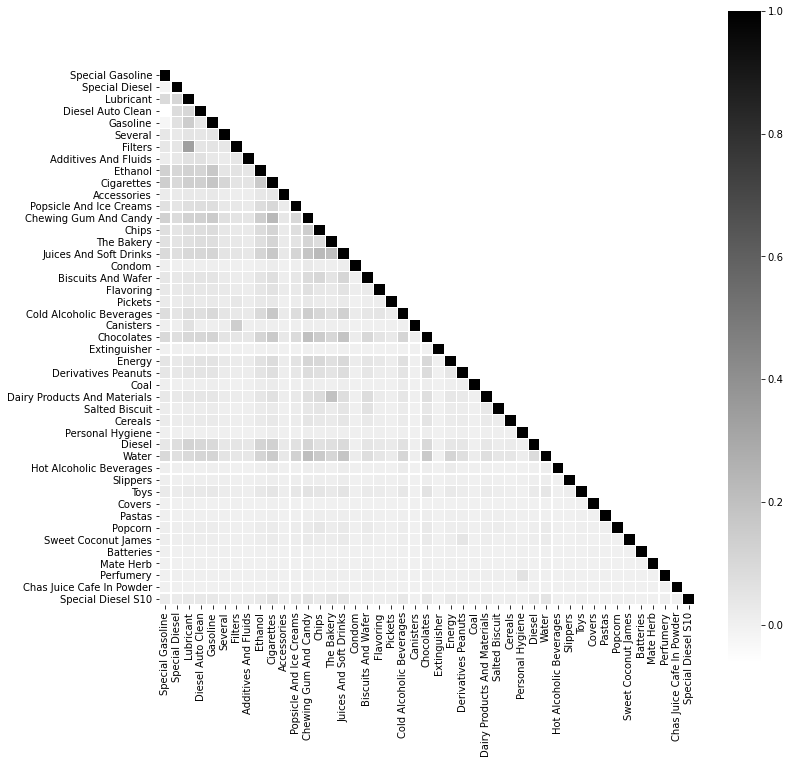

In [50]:
# Plot the triangle
fig, ax = plt.subplots(figsize=(12,12))
df_lt = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
sns.heatmap(df_lt, cmap='binary', square=True, linewidths=0.2)
plt.show()

### Distance Function
We need a minimum spanning tree, which implies that the smaller the edge value, 
the higher the correlation between the nodes it connects.

To do this, we apply the distance function $\sqrt{2(1-x)}$ over the correlation values to transform them as such

In [51]:
# A vectorized distance function that can be 
# applied simultaneously over the entire matrix
def dfunc(x):
    return np.sqrt(2 * (1 - x))

To demonstrate this, this graph shows the effect of the distance function on the correlation values

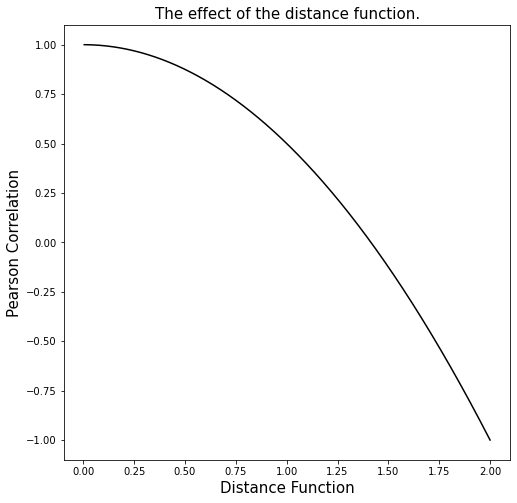

In [52]:
temp = np.arange(-1, 1, 0.00001)
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(dfunc(temp), temp, 'k')
plt.xlabel("Distance Function", fontsize=15)
plt.ylabel("Pearson Correlation", fontsize=15)
plt.title("The effect of the distance function.", fontsize=15)
plt.show()

# Graph Generation
Here we will generate and illustrate both the complete graph and the resulting minimum spanning tree.

In [54]:
# Extract column names from vectors dataframe
columns = vectors.columns

# Dictionary used to map each node index to its respective label
labels = {i:columns[i] for i in range(len(columns))}


# Convert the correlation dataframe to a numpy matrix and apply distance function
corr_distanced = np.array(dfunc(corr))

# Generate a graph from the correlation matrix, reading it in as an adjacency matrix
G = nx.from_numpy_matrix(corr_distanced)

# Generate the minimum spanning tree from the above graph
MST = nx.minimum_spanning_tree(G)

### Plot the resulting graphs

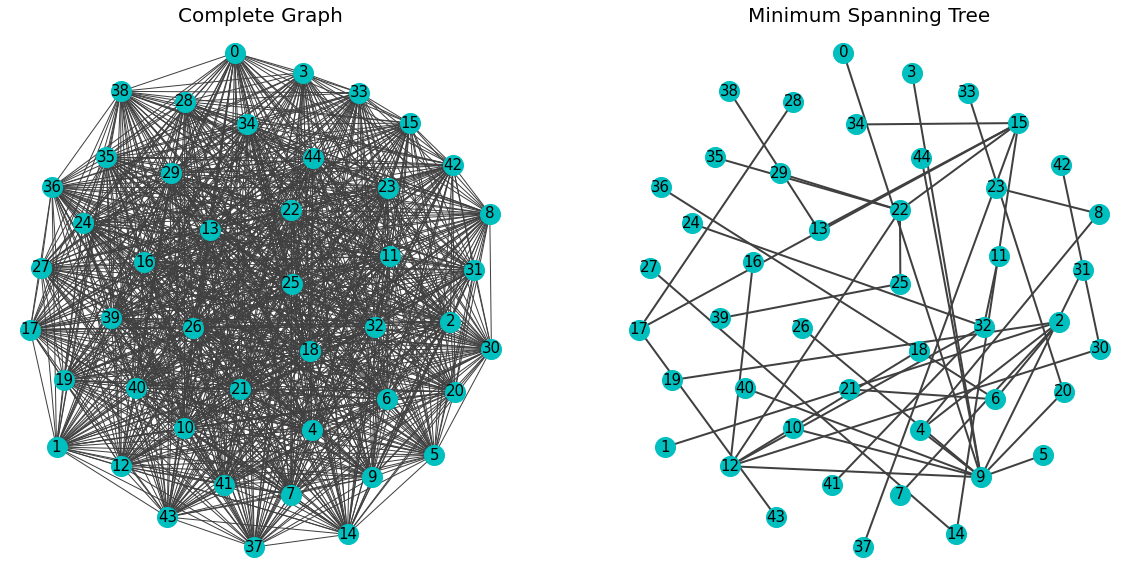

In [38]:
nrows, ncols = 1,2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))

# Set titles
ax[0].set_title("Complete Graph", fontsize=20)
ax[1].set_title("Minimum Spanning Tree", fontsize=20)

# Fixed positional layout for nodes
pos = nx.spring_layout(G)

# Collection of plotting arguments common amongst the two functions
kwargs= dict(pos=pos, with_labels=True, node_color='c',node_size=400, edge_color='0.25', font_size=15)

# Plot the complete graph
nx.draw(G, ax=ax[0], width=1, **kwargs)

# Plot the MSt
nx.draw(MST, ax=ax[1], width=2, **kwargs)

# Cluster Identification 
Markov Clustering is used to identify potential clusters within the graph.

### Parameter Selection
To identify the ideal inflation value to use, we test values from 1.5 to 2.6, using the modularity of the resulting matrix to assess the values, the higher the better. The best inflation score is used to identify the optimal clusters.

In [39]:
def get_optimal_clusters(matrix):
    best_score = (-math.inf)
    best_clusters = None
    inflation_ranges = np.arange(1.5, 2.6, 0.1)
    for inflation in inflation_ranges:
        result = mc.run_mcl(matrix, inflation=inflation)
        clusters = mc.get_clusters(result)
        Q = mc.modularity(matrix=result, clusters=clusters)
        if Q > best_score:
            best_score = Q
            best_clusters = clusters
    return best_clusters

In [40]:
# Extract sparse matrix from MST
matrix = nx.to_scipy_sparse_matrix(MST)

# Identify clusters
clusters = get_optimal_clusters(matrix)

# map node to cluster id for colors
cluster_map = {node: i for i, cluster in enumerate(clusters) for node in cluster}
colors = [cluster_map[i] for i in range(len(MST.nodes()))]

### Plot the MST and the Clustered MST 

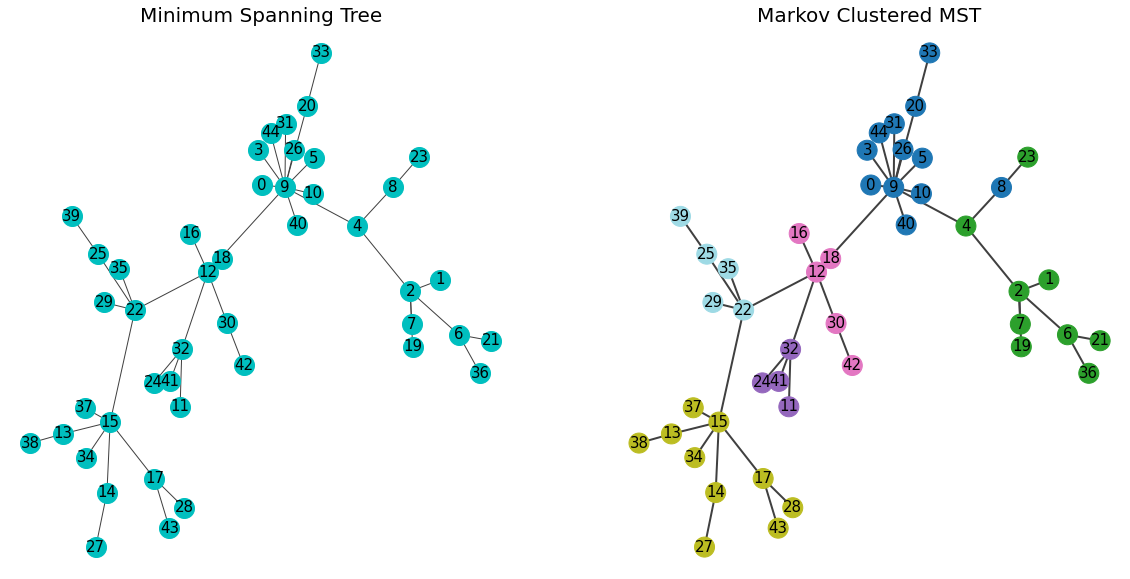

In [44]:
nrows, ncols = 1,2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))

# Set titles
ax[0].set_title("Minimum Spanning Tree", fontsize=20)
ax[1].set_title("Markov Clustered MST", fontsize=20)

# Fixed positional layout for nodes
pos = nx.spring_layout(MST)

# Collection of plotting arguments common amongst the two functions
kwargs= dict(pos=pos, with_labels=True,node_size=400, edge_color='0.25', font_size=15)

# Plot the MST
nx.draw(MST, ax=ax[0], node_color='c', width=1, **kwargs)

# Plot the Markov Clustered MST
nx.draw(MST, node_color=colors, cmap=cm.tab20, ax=ax[1], width=2, **kwargs)

### Print Clusters Identified

In [13]:
for x, cluster in enumerate(clusters):
    if len(cluster) <= 5: # Don't print long ones
        named = [columns[i] for i in cluster]
        print(f'Cluster #{x}: {", ".join(named)}\n')

Cluster #2: Popsicle And Ice Creams, Energy, Water, Mate Herb

Cluster #3: Chewing Gum And Candy, Condom, Flavoring, Personal Hygiene, Perfumery

Cluster #5: Chocolates, Derivatives Peanuts, Cereals, Toys, Sweet Coconut James



In [14]:
def rules(graph, clusters, labels):
    """
    Generate association rules via two criteria:
    - Edges that connect nodes from two different clusters
    - Strongest edges by support, confidence and lift score. 
    """
    
    # Dict mapping each node to its cluster
    parents = {}
    for i, c in enumerate(clusters):
        for node in c:
            parents[node] = i
    
    connectors = [] # edges to return
    
    # Find edges that connect two clusters
    for n1,n2 in graph.edges:
        if parents[n1] != parents[n2]:
            connectors.append((f'{labels[n1]} ({n1}), {labels[n2]} ({n2})'))
            connectors.append((f'{labels[n2]} ({n2}), {labels[n1]} ({n1})'))
            
    # TODO: Cross check Confidence/Support to filter out weak rules
    
    return connectors

In [15]:
rules(MST, clusters, labels)

['Gasoline (4), Cigarettes (9)',
 'Cigarettes (9), Gasoline (4)',
 'Gasoline (4), Ethanol (8)',
 'Ethanol (8), Gasoline (4)',
 'Cigarettes (9), Chewing Gum And Candy (12)',
 'Chewing Gum And Candy (12), Cigarettes (9)',
 'Chewing Gum And Candy (12), Water (32)',
 'Water (32), Chewing Gum And Candy (12)',
 'Chewing Gum And Candy (12), Chocolates (22)',
 'Chocolates (22), Chewing Gum And Candy (12)',
 'Juices And Soft Drinks (15), Chocolates (22)',
 'Chocolates (22), Juices And Soft Drinks (15)']